# Deploying and working with distributed in-memory data structures based on Hazelcast: Distributed Map

In [1]:
import hazelcast
from time import sleep

In [2]:
def print_map_res(input_map):
    if(input_map.size().result() == 0):
        print("Map is empty")
    for (key, value) in input_map.entry_set().result():
        print(key, value)

def print_map(input_map):
    if(input_map.size() == 0):
        print("Map is empty")
    for (key, value) in input_map.entry_set():
        print(key, value)
        
def print_map_tr(input_map):
    if(input_map.size() == 0):
        print("Map is empty")
    for key in input_map.key_set():
        print(key, input_map.get(key))

Used tutorial:
- https://github.com/hazelcast/hazelcast-python-client
- http://hazelcast.github.io/hazelcast-python-client/3.7.2/api/

Hazelcast is a distributed data warehouse in RAM.
“Distributed” means that on each of the nodes (servers) of the system, its own instance of Hazelcast is launched,
which are then combined into a common cluster.
Within this cluster, through the API, you can create different distributed data structures: Map, Queue, Topic,
Lock, ...
Your application, that will run on the same node where the Hazelcast instance is running,
will have access to these distributed data structures, and can write / read to / from them.
At the same time, another application running on a node with another instance of Hazelcast will
also see changes in distributed data structures, and can also write / read to / from them.
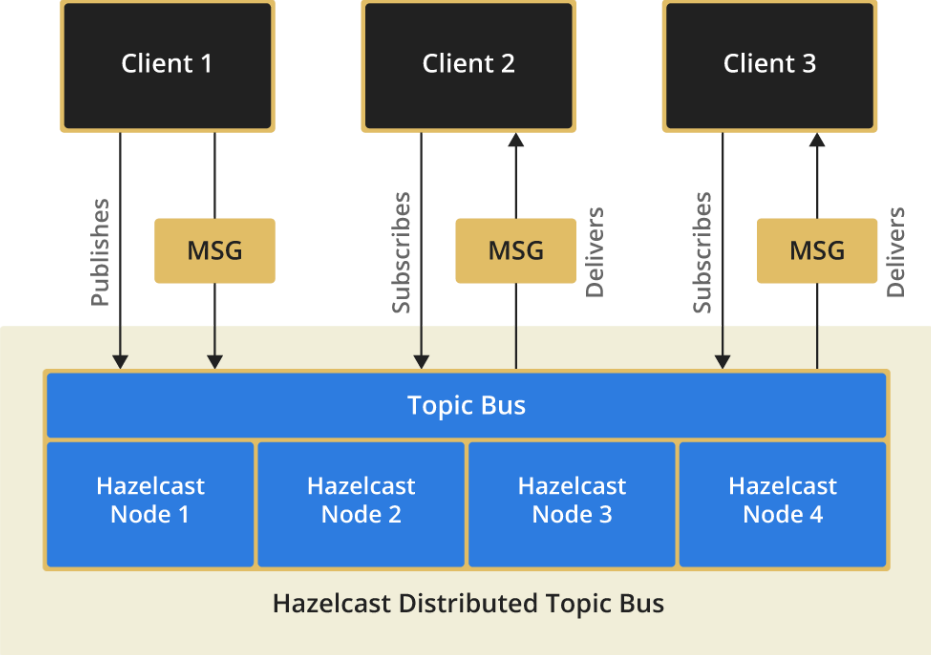

## 1. Install and configure Hazelcast:
http://hazelcast.org/download/

## 2. Configure and run 3 nodes (instances):
https://hazelcast.org/getting-started-with-hazelcast/

In [3]:
config = hazelcast.ClientConfig()
config.network_config.addresses.append("192.168.1.103:5701")
client = hazelcast.HazelcastClient(config)

May 10, 2019 07:32:00 PM HazelcastClient
INFO: [3.11] [dev] [hz.client_0] A non-empty group password is configured for the Hazelcast client. Starting with Hazelcast IMDG version 3.11, clients with the same group name, but with different group passwords (that do not use authentication) will be accepted to a cluster. The group password configuration will be removed completely in a future release.
May 10, 2019 07:32:00 PM HazelcastClient.LifecycleService
INFO: [3.11] [dev] [hz.client_0] (20190319 - 3b38a46) HazelcastClient is STARTING
May 10, 2019 07:32:00 PM HazelcastClient.ClusterService
INFO: [3.11] [dev] [hz.client_0] Connecting to Address(host=192.168.1.103, port=5701)
May 10, 2019 07:32:00 PM HazelcastClient.ConnectionManager
INFO: [3.11] [dev] [hz.client_0] Authenticated with <hazelcast.reactor.AsyncoreConnection connected 192.168.1.103:5701 at 0x7effa3b09908>
May 10, 2019 07:32:00 PM HazelcastClient.ClusterService
INFO: [3.11] [dev] [hz.client_0] New member list:

Members [2] {
	M

## 3. Demonstrate a work of Distributed Map:
http://docs.hazelcast.org/docs/latest/manual/html-single/index.html#map

## 4. Lose data in the Map
Lose part of data in the Map by setting different values of backup and by turning off nodes:
http://docs.hazelcast.org/docs/latest/manual/html-single/index.html#backing-up-maps

In `hazelcast-folder/bin/hazelcast.xml` change `bachup-count` for `map` so that it equals `number of nodes - 1`.
Then all the data will be stored in all nodes.
If `backup-count` is less, then part of data will be lost after turning off nodes.
Also, add the next property
```
<properties>
   <property name="hazelcast.shutdownhook.policy">GRACEFUL</property>
 </properties>
 ```

## 5. Distributed Map with locks
Demonstrate how Distributed Map with locks works by running examples of counting values in a non-blocking loop; with pessimistic; and optimistic locks:
http://docs.hazelcast.org/docs/latest/manual/html-single/index.html#locking-maps

In [4]:
m = client.get_map('m').blocking()
m.put_if_absent(0, 0)

2156

In [5]:
# without lock
print("Starting")
for k in range(1000):
    value = m.get(0)
    m.put(0, value + 1)
print("Finished! Result = {}".format(m.get(0)))

Starting
Finished! Result = 3156


In [6]:
# pessimistic locking
key = "char"
m.put_if_absent(key, 0)
print("Starting")
for k in range(1000):
    m.lock(key)
    try:
        value = m.get(key)
        value = value + 1
        m.put(key, value)
    finally:
        m.unlock(key)
print("Finished! Result = {}".format(m.get(key)))

May 10, 2019 07:32:02 PM HazelcastClient.ConnectionManager
INFO: [3.11] [dev] [hz.client_0] Authenticated with <hazelcast.reactor.AsyncoreConnection connected 192.168.1.103:5702 at 0x7effa327a828>


Starting
Finished! Result = 3000


In [7]:
# optimistic locking
print("Starting")
key = "1"
m.put_if_absent(key, 0)
for i in range(1000):
    while True:
        oldValue = m.get(key)
        newValue = oldValue
        newValue = newValue + 1
        if m.replace_if_same(key, oldValue, newValue):
            break;
print("Result = {0}".format(m.get(key)))

Starting
Result = 2000


Optimistic method compares values in object or data forms depending on the in-memory format configuration.
If the values are equal, it replaces the old value with the new one.
If you want to use your defined equals method, in-memory-format should be OBJECT.
Otherwise, Hazelcast serializes objects to BINARY forms and compares them.

In [8]:
def replace_if(m, key, oldValue):
    if m.contains_key(key) and m.get(key) == oldValue:
        m.put_if_absent(key, newValue)
        return True
    return False

In [9]:
# optimistic locking without replace
print("Starting")
key = "2"
m.put_if_absent(key, 0)
for i in range(1000):
    while True:
        oldValue = m.get(key)
        newValue = oldValue
        newValue = newValue + 1
        if replace_if(m, key, oldValue):
            break;
print("Result = {0}".format(m.get(key)))

Starting
Result = 0


## 6. Demonstrate a work of Replicated Map:
http://docs.hazelcast.org/docs/latest/manual/html-single/index.html#replicated-map

Check the work of Replicated Map in the case of network partitioning

In [10]:
m_rep = client.get_replicated_map("m_rep")

In [11]:
for i in range(100):
    m_rep.put(i, "value")

In [12]:
print_map_res(m_rep)

2 value
70 value
27 value
49 value
0 value
45 value
79 value
14 value
6 value
19 value
61 value
1 value
37 value
18 value
65 value
77 value
94 value
20 value
78 value
73 value
9 value
72 value
86 value
71 value
69 value
51 value
84 value
32 value
93 value
30 value
10 value
98 value
75 value
38 value
47 value
26 value
57 value
12 value
50 value
24 value
22 value
81 value
39 value
58 value
59 value
68 value
92 value
85 value
64 value
17 value
43 value
46 value
53 value
7 value
90 value
97 value
56 value
74 value
66 value
48 value
8 value
25 value
5 value
29 value
82 value
11 value
44 value
42 value
91 value
4 value
23 value
55 value
67 value
96 value
36 value
88 value
34 value
63 value
33 value
83 value
40 value
99 value
41 value
15 value
16 value
28 value
89 value
31 value
62 value
3 value
87 value
21 value
54 value
95 value
35 value
60 value
76 value
80 value
13 value
52 value


## 7. Implement a distributed 2PC transaction:
http://docs.hazelcast.org/docs/latest/manual/html-single/index.html#transactions

In [13]:
# Create a Transaction object and begin the transaction
transaction = client.new_transaction(timeout=10)
transaction.begin()

# Get transactional distributed data structures
txn_map = transaction.get_map("tr-map")
cl_map = client.get_map("tr-map")

try:
    txn_map.put("1", "value3")
    print_map_res(cl_map)
    
    transaction.commit()    
    print_map_res(cl_map)
    
except Exception as ex:
    # In the case of a transactional failure, rollback the transaction 
    transaction.rollback()
    print("Transaction failed! {}".format(ex.args))

1 value3
1 value3


In [14]:
cl_map = client.get_map("tr-map")

In [15]:
print_map_res(cl_map)

1 value3


In [16]:
while True:
    print_map_res(cl_map)
    if cl_map.size().result() > 0:
        break;

1 value3


## 8. Demonstrate a work of Distributed IdGenerator:
http://docs.hazelcast.org/docs/latest/manual/html-single/index.html#idgenerator

In [17]:
# Get a Flake ID Generator called 'flake-id-generator'
generator = client.get_id_generator("flake-id-generator").blocking()

# Generate a some unique identifier
for i in range(1000):
    print("ID: {}".format(generator.new_id()))

ID: 10000
ID: 10001
ID: 10002
ID: 10003
ID: 10004
ID: 10005
ID: 10006
ID: 10007
ID: 10008
ID: 10009
ID: 10010
ID: 10011
ID: 10012
ID: 10013
ID: 10014
ID: 10015
ID: 10016
ID: 10017
ID: 10018
ID: 10019
ID: 10020
ID: 10021
ID: 10022
ID: 10023
ID: 10024
ID: 10025
ID: 10026
ID: 10027
ID: 10028
ID: 10029
ID: 10030
ID: 10031
ID: 10032
ID: 10033
ID: 10034
ID: 10035
ID: 10036
ID: 10037
ID: 10038
ID: 10039
ID: 10040
ID: 10041
ID: 10042
ID: 10043
ID: 10044
ID: 10045
ID: 10046
ID: 10047
ID: 10048
ID: 10049
ID: 10050
ID: 10051
ID: 10052
ID: 10053
ID: 10054
ID: 10055
ID: 10056
ID: 10057
ID: 10058
ID: 10059
ID: 10060
ID: 10061
ID: 10062
ID: 10063
ID: 10064
ID: 10065
ID: 10066
ID: 10067
ID: 10068
ID: 10069
ID: 10070
ID: 10071
ID: 10072
ID: 10073
ID: 10074
ID: 10075
ID: 10076
ID: 10077
ID: 10078
ID: 10079
ID: 10080
ID: 10081
ID: 10082
ID: 10083
ID: 10084
ID: 10085
ID: 10086
ID: 10087
ID: 10088
ID: 10089
ID: 10090
ID: 10091
ID: 10092
ID: 10093
ID: 10094
ID: 10095
ID: 10096
ID: 10097
ID: 10098
ID: 10099
